## CIFAR Fastai

`%matplotlib inline` - ensures matplotlib will plot to output cell in notebook
`%reload_ext autoreload, %autoreload 2` - automatically reloads modules if edited

### 载入环境 

In [22]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import sklearn
import matplotlib.pyplot as plt
torch.__version__

'1.0.1'

In [23]:
import fastai
from fastai.vision import *
from fastai.vision import learner
fastai.__version__

'1.0.50.post1'

### 加载与预处理数据

In [27]:
path = untar_data(URLs.CIFAR, fname = '../../data/cifar');
path # output >>> PosixPath('/home/jupyter/.fastai/data/cifar10')
# dataset folder structure
path.ls() # output >>> ['test', 'labels.txt', 'train']

C:\Users\HYJ\Anaconda3\envs\py37fastai10\lib\site-packages\fastai\datasets.py:164: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  with open(fpath, 'r') as yaml_file: return yaml.load(yaml_file)


[WindowsPath('C:/Users/HYJ/.fastai/data/cifar10/labels.txt'),
 WindowsPath('C:/Users/HYJ/.fastai/data/cifar10/models'),
 WindowsPath('C:/Users/HYJ/.fastai/data/cifar10/test'),
 WindowsPath('C:/Users/HYJ/.fastai/data/cifar10/train')]

In [28]:
train_data = path/'train'
train_data

WindowsPath('C:/Users/HYJ/.fastai/data/cifar10/train')

In [29]:
test_data = path/'test'
test_data

WindowsPath('C:/Users/HYJ/.fastai/data/cifar10/test')

In [7]:
bs = 64 # batch size
img_size = 24 # image size

In [8]:
# 随机旋转正负20度
tfms = [rotate(degrees=(-20,20)), symmetric_warp(magnitude=(-0.3,0.3))]

 - 进行数据增广，直接将valid设置为test

In [9]:
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, valid='test', size=img_size, bs = bs,num_workers=0) 
# normalising the dataset using the same normalisation applied to the imagenet dataset
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (50000 items)
x: ImageList
Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24)
y: CategoryList
airplane,airplane,airplane,airplane,airplane
Path: C:\Users\HYJ\.fastai\data\cifar10;

Valid: LabelList (10000 items)
x: ImageList
Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24)
y: CategoryList
airplane,airplane,airplane,airplane,airplane
Path: C:\Users\HYJ\.fastai\data\cifar10;

Test: None

[ImageDataBunch.from_folder](https://docs.fast.ai/vision.data.html#ImageDataBunch.from_folder) 设置`valid`，其中`valid_pct`字段表明valid占据10%的数据

In [33]:
new_data = ImageDataBunch.from_folder(train_data, ds_tfms=tfms, train=train_data, valid='valid', test=test_data,valid_pct=0.1, 
                                      size=img_size, bs = bs,num_workers=0) 
# normalising the dataset using the same normalisation applied to the imagenet dataset
new_data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (45000 items)
x: ImageList
Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24)
y: CategoryList
airplane,airplane,airplane,airplane,airplane
Path: C:\Users\HYJ\.fastai\data\cifar10\train;

Valid: LabelList (5000 items)
x: ImageList
Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24)
y: CategoryList
automobile,truck,ship,truck,airplane
Path: C:\Users\HYJ\.fastai\data\cifar10\train;

Test: LabelList (10000 items)
x: ImageList
Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24)
y: EmptyLabelList
,,,,
Path: C:\Users\HYJ\.fastai\data\cifar10\train

In [34]:
print(data.classes)
len(data.classes),data.c

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


(10, 10)

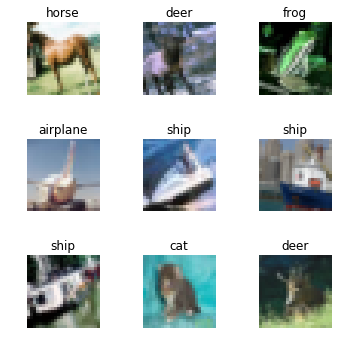

In [101]:
data.show_batch(rows=3, figsize=(5,5))

In [33]:
cnn_learner?

Signature:
cnn_learner(
    data: fastai.basic_data.DataBunch,
    base_arch: Callable,
    cut: Union[int, Callable] = None,
    pretrained: bool = True,
    lin_ftrs: Union[Collection[int], NoneType] = None,
    ps: Union[float, Collection[float]] = 0.5,
    custom_head: Union[torch.nn.modules.module.Module, NoneType] = None,
    split_on: Union[Callable, Collection[Collection[torch.nn.modules.module.Module]], NoneType] = None,
    bn_final: bool = False,
    init=<function kaiming_normal_ at 0x00000197EB530620>,
    concat_pool: bool = True,
    **kwargs: Any,
) -> fastai.basic_train.Learner
Docstring: Build convnet style learner.
File:      c:\users\hyj\anaconda3\envs\py37fastai10\lib\site-packages\fastai\vision\learner.py
Type:      function


模型选用：https://docs.fast.ai/vision.models.html

### ResNet34 without validation set

#### 参考链接

- [用fastai ResNet50训练CIFAR10，85%准确度](https://www.wandouip.com/t5i290554/)
- [CIFAR-10 Method Ranking](https://benchmarks.ai/cifar-10) last updated 2019
- [CIFAR-10 classification_datasets_results](https://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130) last updated 2015
- https://github.com/init27/RTX-2080Ti-Vs-GTX-1080Ti-CIFAR-100-Benchmarks
- [RTX 2080Ti Vs GTX 1080Ti: FastAI Mixed Precision training & comparisons on CIFAR-100](https://hackernoon.com/rtx-2080ti-vs-gtx-1080ti-fastai-mixed-precision-training-comparisons-on-cifar-100-761d8f615d7f)

In [38]:
learn1 = cnn_learner(data=data, base_arch=models.resnet34, metrics=error_rate)

In [41]:
learn1.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.10E-02


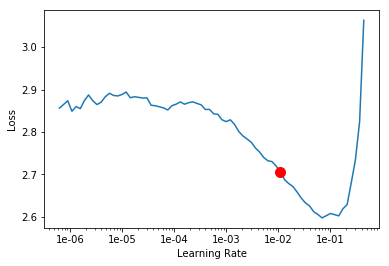

In [42]:
# 画出学习率寻找曲线，给出建议学习率
learn1.recorder.plot(suggestion=True)

`learn1.fit_one_cycle` 原有默认学习率为 **0.003**

In [44]:
# 根据学习率曲线得到max_lr，开始训练
learn1.fit_one_cycle(cyc_len=15, max_lr=1.10E-02)

epoch,train_loss,valid_loss,error_rate,time
0,1.390306,1.336829,0.473900,03:08
1,1.129087,1.167297,0.406900,02:57
2,1.107678,1.197931,0.419900,02:58
3,1.095819,1.120940,0.386100,02:57
4,1.060097,1.069762,0.371900,02:57
5,0.988918,1.139213,0.381800,02:51
6,1.017678,1.035485,0.364300,02:54
7,0.928527,0.997322,0.347800,02:52
8,0.942945,0.951707,0.335600,03:49
9,0.902082,0.961064,0.327800,03:52


In [45]:
learn1.save('res34-stage-1') # saving the model weights

In [46]:
learn1.load('res34-stage-1') # loading the model weights

Learner(data=ImageDataBunch;

Train: LabelList (50000 items)
x: ImageList
Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24)
y: CategoryList
airplane,airplane,airplane,airplane,airplane
Path: C:\Users\HYJ\.fastai\data\cifar10;

Valid: LabelList (10000 items)
x: ImageList
Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24)
y: CategoryList
airplane,airplane,airplane,airplane,airplane
Path: C:\Users\HYJ\.fastai\data\cifar10;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d

In [48]:
learn1.unfreeze()

In [50]:
learn1.lr_find(end_lr=1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


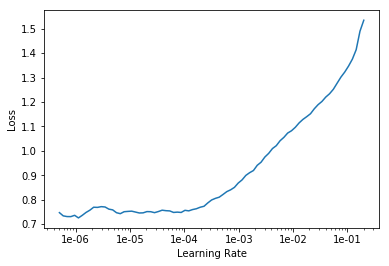

In [53]:
learn1.recorder.plot()

In [55]:
learn1.fit_one_cycle(10, slice(2e-6, 1e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.782025,0.877774,0.305300,04:26
1,0.774211,0.903600,0.306200,04:08
2,0.756491,0.861392,0.299600,04:14
3,0.763104,0.858521,0.300700,04:10
4,0.742118,0.850643,0.295500,03:41
5,0.697710,0.842790,0.294400,03:47
6,0.704682,0.853747,0.300600,03:44
7,0.714265,0.835156,0.292200,03:42
8,0.717225,0.854354,0.297600,03:50
9,0.709184,0.836953,0.292000,03:44


- 评估

In [64]:
learn1.save('res34-stage-2') # saving the model weights

In [56]:
interp = ClassificationInterpretation.from_learner(learn1)

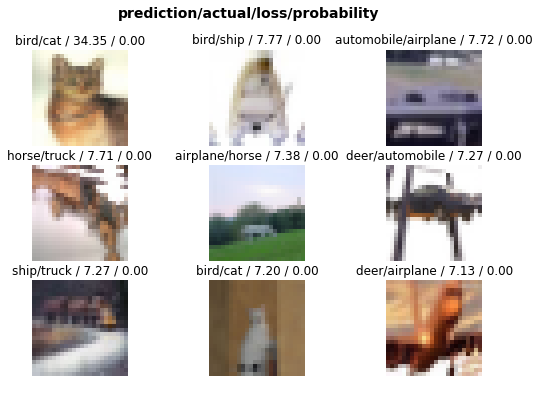

In [57]:
interp.plot_top_losses(9, figsize=(9,6))

In [58]:
#interp.plot_confusion_matrix?

`cmap`可以看 https://matplotlib.org/3.1.1/tutorials/colors/colormaps.html

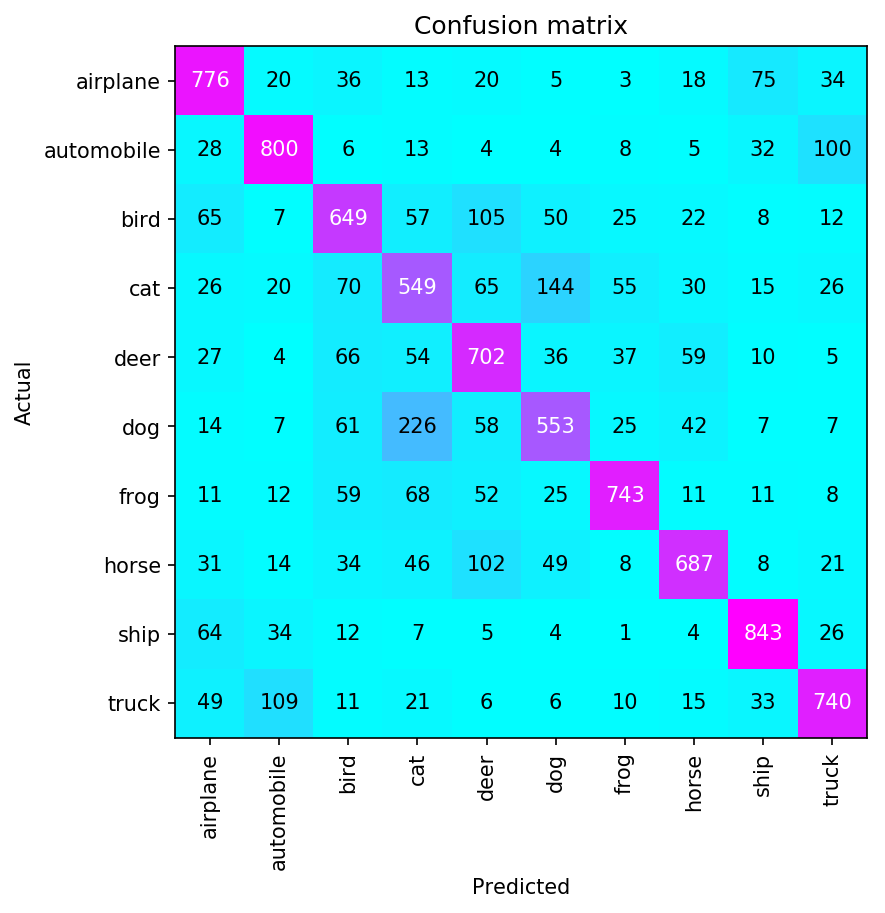

In [62]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=150, cmap='cool')

- 计算超过 40 的类

In [63]:
interp.most_confused(min_val=40)

[('dog', 'cat', 226),
 ('cat', 'dog', 144),
 ('truck', 'automobile', 109),
 ('bird', 'deer', 105),
 ('horse', 'deer', 102),
 ('automobile', 'truck', 100),
 ('airplane', 'ship', 75),
 ('cat', 'bird', 70),
 ('frog', 'cat', 68),
 ('deer', 'bird', 66),
 ('bird', 'airplane', 65),
 ('cat', 'deer', 65),
 ('ship', 'airplane', 64),
 ('dog', 'bird', 61),
 ('deer', 'horse', 59),
 ('frog', 'bird', 59),
 ('dog', 'deer', 58),
 ('bird', 'cat', 57),
 ('cat', 'frog', 55),
 ('deer', 'cat', 54),
 ('frog', 'deer', 52),
 ('bird', 'dog', 50),
 ('horse', 'dog', 49),
 ('truck', 'airplane', 49),
 ('horse', 'cat', 46),
 ('dog', 'horse', 42)]

### ResNet50 with validation set

In [69]:
learn2 = cnn_learner(data=new_data, base_arch=models.resnet50, metrics=error_rate)

In [70]:
learn2.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 9.12E-03


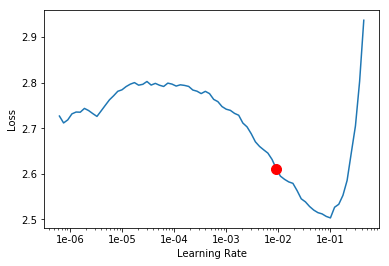

In [71]:
# 画出学习率寻找曲线，给出建议学习率
learn2.recorder.plot(suggestion=True)

In [72]:
learn2.fit_one_cycle(cyc_len=15, max_lr=9.12E-03)

epoch,train_loss,valid_loss,error_rate,time
0,1.365069,1.357458,0.474200,03:27
1,1.102144,1.166417,0.406000,03:28
2,1.035258,1.033650,0.358600,03:30
3,1.011387,1.047086,0.366200,03:34
4,0.957564,0.993538,0.339400,03:31
5,0.951647,1.000391,0.347600,03:12
6,0.910214,1.002255,0.346000,03:15
7,0.866741,0.919583,0.308200,03:10
8,0.813545,0.858688,0.296600,03:11
9,0.759292,0.856918,0.304600,03:14


更换网络，变换学习率，数据增广，使用更深的网络，变换新的学习率

In [73]:
learn2.save('resnet50-stage-1') # saving the model weights

In [81]:
learn2.load('resnet50-stage-1') # loading the model weights

Learner(data=ImageDataBunch;

Train: LabelList (45000 items)
x: ImageList
Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24)
y: CategoryList
airplane,airplane,airplane,airplane,airplane
Path: C:\Users\HYJ\.fastai\data\cifar10\train;

Valid: LabelList (5000 items)
x: ImageList
Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24)
y: CategoryList
automobile,truck,ship,truck,airplane
Path: C:\Users\HYJ\.fastai\data\cifar10\train;

Test: LabelList (10000 items)
x: ImageList
Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24)
y: EmptyLabelList
,,,,
Path: C:\Users\HYJ\.fastai\data\cifar10\train, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, 

In [82]:
learn2.unfreeze()

In [83]:
learn2.lr_find(end_lr=1e-3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.74E-06


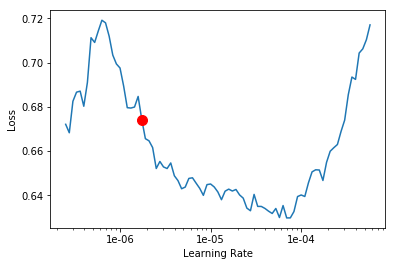

In [84]:
learn2.recorder.plot(suggestion=True)

In [85]:
learn2.fit_one_cycle(15, slice(1e-6, 5e-6))

epoch,train_loss,valid_loss,error_rate,time
0,0.618872,0.797404,0.273800,03:53
1,0.623353,0.803663,0.274400,03:55
2,0.602284,0.818999,0.273000,03:54
3,0.614965,0.904788,0.273600,03:59
4,0.610566,0.771489,0.270600,03:52
5,0.599383,0.782821,0.269200,03:51
6,0.589775,0.789079,0.273400,03:51
7,0.592902,0.765868,0.271400,03:50
8,0.578316,0.796248,0.266200,03:51
9,0.569336,0.768856,0.262200,03:53


In [87]:
learn2.save('resnet50-stage-2') # saving the model weights

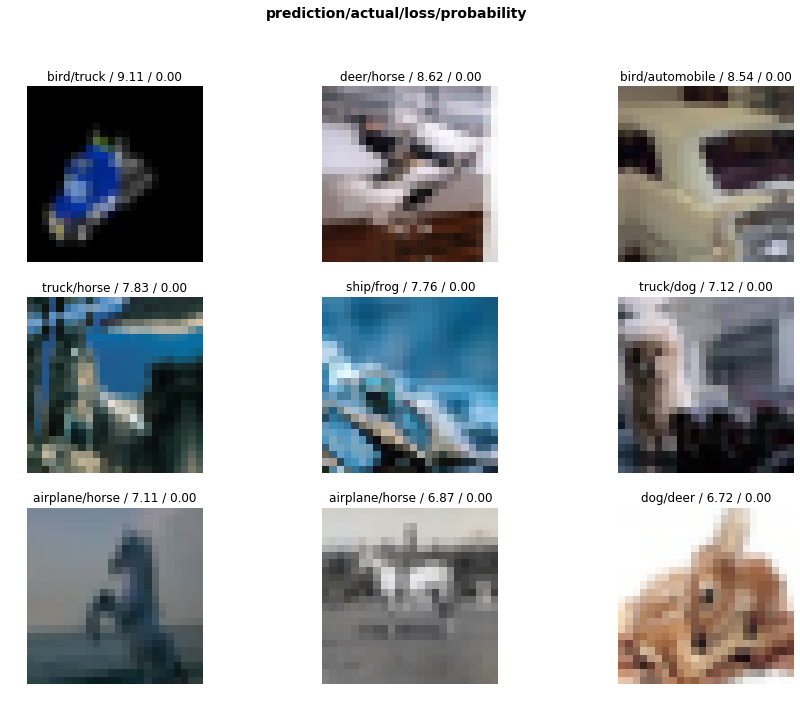

In [86]:
interp2 = ClassificationInterpretation.from_learner(learn2)
interp2.plot_top_losses(9, figsize=(15,11))

In [90]:
interp.most_confused(min_val=40)

[('dog', 'cat', 226),
 ('cat', 'dog', 144),
 ('truck', 'automobile', 109),
 ('bird', 'deer', 105),
 ('horse', 'deer', 102),
 ('automobile', 'truck', 100),
 ('airplane', 'ship', 75),
 ('cat', 'bird', 70),
 ('frog', 'cat', 68),
 ('deer', 'bird', 66),
 ('bird', 'airplane', 65),
 ('cat', 'deer', 65),
 ('ship', 'airplane', 64),
 ('dog', 'bird', 61),
 ('deer', 'horse', 59),
 ('frog', 'bird', 59),
 ('dog', 'deer', 58),
 ('bird', 'cat', 57),
 ('cat', 'frog', 55),
 ('deer', 'cat', 54),
 ('frog', 'deer', 52),
 ('bird', 'dog', 50),
 ('horse', 'dog', 49),
 ('truck', 'airplane', 49),
 ('horse', 'cat', 46),
 ('dog', 'horse', 42)]